<a href="https://colab.research.google.com/github/Saloni1707/Car_Racing/blob/main/Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import math
import random
from dataclasses import dataclass
from typing import List,Tuple,Optional
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from collections import deque
import time

In [8]:
#basic math
@dataclass
class Vector2D:
  x:float
  y:float
  def __add__(self,other):
    return Vector2D(self.x+other.x,self.y+other.y)
  def __sub__(self,other):
    return Vector2D(self.x-other.x,self.y-other.y)
  def __mul__(self,scalar):
    return Vector2D(self.x*scalar,self.y*scalar)
  def magnitude(self):
    return math.sqrt(self.x**2+self.y**2)
  def normalize(self):
    mag = self.magnitude()
    if mag == 0:
      return Vector2D(0,0)
    return Vector2D(self.x/mag,self.y/mag)
  def rotate(self,angle_rad:float):
    cos_a=math.cos(angle_rad)
    sin_a=math.sin(angle_rad)
    return Vector2D(
        self.x*cos_a-self.y*sin_a,
        self.x*sin_a + self.y*cos_a
    )
    def to_array(self):
      return np.array([self.x,self.y])
print("Vector Math Test")
v1=Vector2D(1,0)
v2=v1.rotate(math.pi/2)
print(f"Orginal:({v1.x:.2f},{v1.y:.2f})")
print(f"Rotated:({v2.x:.2f},{v2.y:.2f})")
print(f"Magnitude: {v1.magnitude():.2f}")


Vector Math Test
Orginal:(1.00,0.00)
Rotated:(0.00,1.00)
Magnitude: 1.00


In [9]:
#car physics here
@dataclass
class Car:
  def __init__(self,x:float,y:float,angle:float):
    self.position=Vector2D(x,y)
    self.angle=angle
    self.velocity=Vector2D(0,0)
    self.speed=0
    self.angular_velocity=0
    self.max_speed = 50.0 #pixels/second
    self.max_reverse_speed=-20.0
    self.acceleration=30.0
    self.deceleration=50.0
    self.turn_speed=3.0
    self.width=20
    self.length=40
    self.sensor_ranges=[]

  def update(self,dt:float,throttle:float,steering:float):
    throttle=max(-1,min(1,throttle))
    steering=max(-1,min(1,steering))
    if throttle>0: #here based on throttle inc speed
      self.speed+=self.acceleration*throttle*dt
      self.speed=min(self.speed,self.max_speed)
    elif throttle<0:
      self.speed+=self.acceleration*throttle*dt
      self.speed=max(self.speed,self.max_reverse_speed)
    else:
      if self.speed>0:
        self.speed=max(0,self.speed-self.deceleration*dt)
      else:
        self.speed=min(0,self.speed+self.deceleration*dt)

    if abs(self.speed) > 0.1:  # Only turn when moving
        self.angular_velocity = steering * self.turn_speed * (self.speed / self.max_speed)
        self.angle += self.angular_velocity * dt
        self.angle = self.angle % (2 * math.pi)  # Keep angle in [0, 2π]
    direction = Vector2D(math.cos(self.angle), math.sin(self.angle))
    velocity = direction * self.speed
    self.position = self.position + velocity * dt
    self.velocity = velocity

  def get_state(self):
    return np.array([
        self.position.x,self.position.y,
        self.velocity.x,self.velocity.y,
        self.angle,self.angular_velocity,
        self.speed
    ])
  def reset(self,x:float,y:float,angle:float):
    self.position=Vector2D(x,y)
    self.angle=angle
    self.velocity=Vector2D(0,0)
    self.speed=0
    self.angular_velocity=0

print("Car Simulation")
my_car = Car(0, 0, 0)
print(f"Initial State: {my_car.get_state()}")
for i in range(10):
    my_car.update(dt=0.1, throttle=0.5, steering=0)  # Half throttle, no steering

print(f"After 1s straight: Position({my_car.position.x:.1f}, {my_car.position.y:.1f}), Speed: {my_car.speed:.1f}")

for i in range(10):
    my_car.update(dt=0.1, throttle=0.5, steering=0.5)

print(f"After turning: Position({my_car.position.x:.1f}, {my_car.position.y:.1f}), Angle: {math.degrees(my_car.angle):.1f}°")
print()

Car Simulation
Initial State: [0 0 0 0 0 0 0]
After 1s straight: Position(8.2, 0.0), Speed: 15.0
After turning: Position(29.3, 8.5), Angle: 40.0°



In [10]:
#Our environment
@dataclass
class Environment:
  def __init__(self,width:int,height:int):
    self.width=width
    self.height=height
    self.obstacles=[]
    self.boundary=[]
    self.create_track()

  def create_track(self):
    margin=50
    self.boundary=[
        {"start":Vector2D(0,0),"end":Vector2D(self.width,0)}, #outer boundary top wall
        {"start":Vector2D(0,self.height),"end":Vector2D(self.width,self.height)}, #bottom wall
        {"start":Vector2D(0,0),"end":Vector2D(0,self.height)},#left wall
        {"start":Vector2D(self.width,0),"end":Vector2D(self.width,self.height)},#right wall

        {'start': Vector2D(margin, margin), 'end': Vector2D(self.width-margin, margin)},#Inner boundary box
        {'start': Vector2D(margin, self.height-margin), 'end': Vector2D(self.width-margin, self.height-margin)},
        {'start': Vector2D(margin, margin), 'end': Vector2D(margin, self.height-margin)},
        {'start': Vector2D(self.width-margin, margin), 'end': Vector2D(self.width-margin, self.height-margin)},

    ]


  def is_collision(self,position:Vector2D,car_width:float=20,car_length=40):
    margin=max(car_width,car_length)/2
    if(position.x<margin or position.x>self.width-margin or position.y<margin or position.y>self.height-margin):
      return True
    return False

  def get_track_distance(self,position:Vector2D):
    distances=[]
    distances.append(position.x)
    distances.append(self.width-position.x)
    distances.append(position.y)
    distances.append(self.height-position.y)
    return min(distances)

  def get_start_position(self):
    margin=50
    start_x=margin+30
    start_y=(self.height)//2
    start_angle=0
    start_position=Vector2D(start_x,start_y)
    return start_position,start_angle

  def get_track_boundaries(self):
    margin=50
    left_boundary=[
        Vector2D(0,0),
        Vector2D(0,self.height),
        Vector2D(margin,self.height-margin),
        Vector2D(margin,margin),
        Vector2D(0,0)
    ]
    right_boundary = [
        Vector2D(self.width, 0),
        Vector2D(self.width, self.height),
        Vector2D(self.width - margin, self.height - margin),
        Vector2D(self.width - margin, margin),
        Vector2D(self.width, 0)
    ]
    return left_boundary,right_boundary


print("Test Environment")
env=Environment(width=800, height=600)
test_pos=Vector2D(100,100)
print(f"Position ({test_pos.x}, {test_pos.y}):")
print(f"Collision: {env.is_collision(test_pos)}")
print(f"Distance to boundary: {env.get_track_distance(test_pos):.1f}")
print()

Test Environment
Position (100, 100):
Collision: False
Distance to boundary: 100.0



In [11]:
class CarWithSensors(Car):
  def __init__(self,x:float=0,y:float=0,angle:float=0):
    super().__init__(x,y,angle)
    self.num_sensors=8
    self.sensor_range=100
    self.sensor_angles=[]
    self.sensor_readings=[]

    for i in range(self.num_sensors):
      angle_offset = (i-self.num_sensors/2 + 0.5)*(180/self.num_sensors) #this is the sensor in front of car
      self.sensor_angles.append(math.radians(angle_offset))
    print("This is the angle",self.sensor_angles)

  def update_sensors(self,Environment):
    self.sensor_readings=[]#Based on our env we update sensor readings here

    for sensor_angle in self.sensor_angles:
      world_angle=self.angle+sensor_angle
      ray_dx=math.cos(world_angle)
      ray_dy=math.sin(world_angle)#ray directions of our sensors

      distance=self.cast_ray(ray_dx,ray_dy,Environment)
      self.sensor_readings.append(distance)

  def cast_ray(self,dx:float,dy:float,Environment):
    step_size=2
    max_steps=int(self.sensor_range/step_size)

    for step in range(max_steps):
      ray_x=self.position.x+dx*step*step_size
      ray_y=self.position.y+dy*step*step_size
      ray_pos = Vector2D(ray_x,ray_y) #chk if ray hit the boundary
      if Environment.is_collision(ray_pos,car_width=1):
        return step*step_size

    return self.sensor_range #ray didn't hit anything all good

  def get_sensor_state(self):
    normalized_readings=[reading/self.sensor_range for reading in self.sensor_readings]
    return np.array(normalized_readings)

  def get_full_state(self):
    car_state=super().get_state()
    sensor_state=self.get_sensor_state()
    return np.concatenate([car_state,sensor_state])

print("Sensor with car test")
env=Environment(width=800,height=600)
sensor_car=CarWithSensors(100,300,0)
sensor_car.update_sensors(env)
print(f"Sensor Readings: {sensor_car.sensor_readings}")
print(f"Sensor State: {sensor_car.get_sensor_state()}")


Sensor with car test
This is the angle [-1.3744467859455345, -0.9817477042468103, -0.5890486225480862, -0.19634954084936207, 0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345]
Sensor Readings: [100, 100, 100, 100, 100, 100, 100, 100]
Sensor State: [1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
import torch.nn.functional as F
class DQN(nn.Module):
  def __init__(self,state_size,action_size,hidden=256):
    super(DQN,self).__init__()
    self.network=nn.Sequential(
        nn.Linear(state_size,hidden),
        nn.ReLU(),
        nn.Linear(hidden,hidden),
        nn.ReLU(),
        nn.Linear(hidden,128),
        nn.ReLU(),
        nn.Linear(128,action_size)
    )
  def forward(self,x):
    return self.network(x)

class DQNAgent:
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.q_network = DQN(state_size, action_size)
        self.target_network = DQN(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = deque(maxlen=10000)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.action_map = [
            (1.0, 0.0),   # Forward
            (0.8, 0.5),   # Forward right
            (0.8, -0.5),  # Forward left
            (0.5, 1.0),   # Sharp right
            (0.5, -1.0),  # Sharp left
            (0.0, 0.0),   # Brake
            (-0.5, 0.0),  # Reverse
            (0.6, 0.8),   # Moderate right
            (0.6, -0.8),  # Moderate left
        ]

    def get_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            action_idx = random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            action_idx = torch.argmax(q_values).item()

        return self.action_map[action_idx], action_idx

    def transition(self, state, action_idx, reward, next_state, done):
        self.memory.append((state, action_idx, reward, next_state, done))

    def update(self):
        if len(self.memory) < 64:
            return

        batch = random.sample(self.memory, 64)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states))
        next_states = torch.FloatTensor(np.array(next_states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = F.mse_loss(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [15]:
class DataCollector:
  def __init__(self,max_samples:int=10000):
    self.states=[]
    self.actions=[]
    self.rewards=[]
    self.max_samples=max_samples

  def add_sample(self,state:np.ndarray,action:np.ndarray,reward:float):
    self.states.append(state.copy())
    self.actions.append(action.copy())
    self.rewards.append(reward)

    if(len(self.states)>self.max_samples):
      self.states.pop(0) #sliding window type
      self.actions.pop(0)
      self.rewards.pop(0)

  def get_data(self,batch_size:int=32):
    if(len(self.states)<batch_size):
      return None,None,None

    indices=random.sample(range(len(self.states)),batch_size)
    batch_states=[self.states[i] for i in indices]
    batch_actions=[self.actions[i] for i in indices]
    batch_rewards=[self.rewards[i] for i in indices]

    return(
        torch.FloatTensor(batch_states),
        torch.FloatTensor(batch_actions),
        torch.FloatTensor(batch_rewards)
    )

  def clear(self):
    self.states.clear()
    self.actions.clear()
    self.rewards.clear()

In [16]:
class RewardSystem:
  def __init__(self):
    self.prev_position=None
    self.prev_distance=None
  def calculate_reward(self,car:Car,env:Environment):
    reward=0
    if not env.is_collision(car.position):
      reward += 1.0
      speed_reward = min(car.speed / car.max_speed,1.0)*0.5 #speed reward
      reward += speed_reward

      distance_track=env.get_track_distance(car.position)
      if distance_track < 20:
        reward += 0.3
      if distance_track > 40:
        reward-=0.2
    else:
      reward = -10.0
    if abs(car.speed) < 1.0:
      reward -=0.1

    return reward

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle, Polygon
import numpy as np
from IPython.display import HTML

class CarSimulation:
    def __init__(self, width=800, height=600):
        self.env = Environment(width, height)
        self.car = CarWithSensors()
        self.agent = DQNAgent(state_size=15, action_size=9)  # 7 car states + 8 sensors
        self.reward_system = RewardSystem()

        start_pos, start_angle = self.env.get_start_position()
        self.car.reset(start_pos.x, start_pos.y, start_angle)
        self.episode_rewards = []
        self.episode_steps = []
        self.current_episode = 0
        self.current_reward = 0
        self.step_count = 0

    def run_episode(self, max_steps=1000):
        start_pos, start_angle = self.env.get_start_position()
        self.car.reset(start_pos.x, start_pos.y, start_angle)
        episode_data = {
            'positions': [],
            'actions': [],
            'rewards': [],
            'sensor_readings': [],
            'collisions': []
        }

        total_reward = 0

        for step in range(max_steps):
            self.car.update_sensors(self.env)
            state = self.car.get_full_state()
            action, action_idx = self.agent.get_action(state, training=True)
            throttle, steering = action
            prev_pos = Vector2D(self.car.position.x, self.car.position.y)
            self.car.update(dt=0.05, throttle=throttle, steering=steering)
            reward = self.reward_system.calculate_reward(self.car, self.env)
            total_reward += reward
            collision = self.env.is_collision(self.car.position)
            episode_data['positions'].append((self.car.position.x, self.car.position.y))
            episode_data['actions'].append(action)
            episode_data['rewards'].append(reward)
            episode_data['sensor_readings'].append(self.car.sensor_readings.copy())
            episode_data['collisions'].append(collision)


            self.car.update_sensors(self.env)
            next_state = self.car.get_full_state()

            self.agent.transition(state, action_idx, reward, next_state, collision)

            if len(self.agent.memory) > 100:
                self.agent.update()

            if collision:
                break

        if self.current_episode % 10 == 0:
            self.agent.update_target_network()

        self.episode_rewards.append(total_reward)
        self.episode_steps.append(step + 1)
        self.current_episode += 1

        return episode_data

class CarVisualizer:
    def __init__(self, simulation):
        self.sim = simulation
        self.fig, (self.ax_main, self.ax_metrics) = plt.subplots(1, 2, figsize=(15, 8))

        self.ax_main.set_xlim(0, self.sim.env.width)
        self.ax_main.set_ylim(0, self.sim.env.height)
        self.ax_main.set_aspect('equal')
        self.ax_main.set_title('Car DQN Training - Live View')
        self.ax_main.set_facecolor('#1a1a1a')

        self.draw_track()

        self.ax_metrics.set_title('Training Metrics')
        self.ax_metrics.set_xlabel('Episode')
        self.ax_metrics.set_ylabel('Reward')
        self.ax_metrics.grid(True, alpha=0.3)

        self.car_body = None
        self.sensor_lines = []
        self.trail = []

    def draw_track(self):
        margin = 50

        # Outer boundaries (walls)
        outer_walls = [
            Rectangle((0, 0), self.sim.env.width, 10, facecolor='red', alpha=0.8),
            Rectangle((0, self.sim.env.height-10), self.sim.env.width, 10, facecolor='red', alpha=0.8),
            Rectangle((0, 0), 10, self.sim.env.height, facecolor='red', alpha=0.8),
            Rectangle((self.sim.env.width-10, 0), 10, self.sim.env.height, facecolor='red', alpha=0.8)
        ]

        inner_walls = [
            Rectangle((margin, margin), self.sim.env.width-2*margin, 10, facecolor='red', alpha=0.8),
            Rectangle((margin, self.sim.env.height-margin-10), self.sim.env.width-2*margin, 10, facecolor='red', alpha=0.8),
            Rectangle((margin, margin), 10, self.sim.env.height-2*margin, facecolor='red', alpha=0.8),
            Rectangle((self.sim.env.width-margin-10, margin), 10, self.sim.env.height-2*margin, facecolor='red', alpha=0.8)
        ]

        for wall in outer_walls + inner_walls:
            self.ax_main.add_patch(wall)

        track_surface = Rectangle((10, 10), self.sim.env.width-20, self.sim.env.height-20,
                                facecolor='#2d4a22', alpha=0.3, edgecolor='white', linewidth=1)
        self.ax_main.add_patch(track_surface)

        start_pos, _ = self.sim.env.get_start_position()
        start_line = Rectangle((start_pos.x-2, 50), 4, self.sim.env.height-100,
                             facecolor='yellow', alpha=0.8)
        self.ax_main.add_patch(start_line)

    def draw_car(self, position, angle, sensor_readings, collision=False):
        if self.car_body:
            self.car_body.remove()
        for line in self.sensor_lines:
            line.remove()
        self.sensor_lines.clear()

        car_length = 40
        car_width = 20

        corners = np.array([
            [-car_length/2, -car_width/2],
            [car_length/2, -car_width/2],
            [car_length/2, car_width/2],
            [-car_length/2, car_width/2]
        ])

        cos_a, sin_a = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
        rotated_corners = corners @ rotation_matrix.T

        car_corners = rotated_corners + np.array([position.x, position.y])

        car_color = 'red' if collision else 'cyan'
        self.car_body = Polygon(car_corners, facecolor=car_color, edgecolor='white', linewidth=2)
        self.ax_main.add_patch(self.car_body)

        for i, (sensor_angle, reading) in enumerate(zip(self.sim.car.sensor_angles, sensor_readings)):
            world_angle = angle + sensor_angle
            end_x = position.x + reading * np.cos(world_angle)
            end_y = position.y + reading * np.sin(world_angle)

            color_intensity = reading / self.sim.car.sensor_range
            color = (1 - color_intensity, color_intensity, 0, 0.6)

            line = self.ax_main.plot([position.x, end_x], [position.y, end_y],
                                   color=color, linewidth=1, alpha=0.7)[0]
            self.sensor_lines.append(line)

        self.trail.append((position.x, position.y))
        if len(self.trail) > 100:
            self.trail.pop(0)

        if len(self.trail) > 1:
            trail_x, trail_y = zip(*self.trail)
            self.ax_main.plot(trail_x, trail_y, color='white', alpha=0.3, linewidth=1)

    def update_metrics(self):
        """Update the metrics plot"""
        self.ax_metrics.clear()
        self.ax_metrics.set_title(f'Training Metrics (Episode {self.sim.current_episode})')
        self.ax_metrics.set_xlabel('Episode')
        self.ax_metrics.set_ylabel('Total Reward')
        self.ax_metrics.grid(True, alpha=0.3)

        if len(self.sim.episode_rewards) > 0:
            episodes = range(len(self.sim.episode_rewards))
            self.ax_metrics.plot(episodes, self.sim.episode_rewards, 'b-', alpha=0.7, label='Episode Reward')

            if len(self.sim.episode_rewards) >= 10:
                window = 10
                moving_avg = []
                for i in range(window-1, len(self.sim.episode_rewards)):
                    avg = np.mean(self.sim.episode_rewards[i-window+1:i+1])
                    moving_avg.append(avg)

                avg_episodes = range(window-1, len(self.sim.episode_rewards))
                self.ax_metrics.plot(avg_episodes, moving_avg, 'r-', linewidth=2, label=f'{window}-Episode Average')

            self.ax_metrics.legend()
            self.ax_metrics.text(0.02, 0.98, f'Epsilon: {self.sim.agent.epsilon:.3f}',
                               transform=self.ax_metrics.transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

def run_training_visualization(num_episodes=50):
    sim = CarSimulation()
    visualizer = CarVisualizer(sim)

    for episode in range(num_episodes):
        print(f"Running Episode {episode + 1}/{num_episodes}...")
        episode_data = sim.run_episode()

        visualizer.trail.clear()

        final_pos_idx = len(episode_data['positions']) - 1
        if final_pos_idx >= 0:
            final_pos = episode_data['positions'][final_pos_idx]
            final_sensors = episode_data['sensor_readings'][final_pos_idx]
            collision = episode_data['collisions'][final_pos_idx]

            visualizer.draw_car(
                Vector2D(final_pos[0], final_pos[1]),
                sim.car.angle,
                final_sensors,
                collision
            )

        visualizer.update_metrics()
        total_reward = sum(episode_data['rewards'])
        steps = len(episode_data['positions'])
        collision_occurred = any(episode_data['collisions'])

        print(f"  Episode {episode + 1}: Reward = {total_reward:.2f}, Steps = {steps}, Collision = {collision_occurred}")

        if (episode + 1) % 5 == 0:
            plt.tight_layout()
            plt.show()
            if episode + 1 < num_episodes:
                visualizer = CarVisualizer(sim)

    plt.tight_layout()
    plt.show()

    print(f"Total episodes: {len(sim.episode_rewards)}")
    print(f"Average reward (last 10 episodes): {np.mean(sim.episode_rewards[-10:]):.2f}")
    print(f"Best episode reward: {max(sim.episode_rewards):.2f}")
    print(f"Final epsilon: {sim.agent.epsilon:.3f}")

This is the angle [-1.3744467859455345, -0.9817477042468103, -0.5890486225480862, -0.19634954084936207, 0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345]
Starting DQN Training Visualization...
The car will learn to navigate the track while avoiding collisions.
Red car = collision, Cyan car = normal
Sensor lines: Red = obstacle close, Green = clear path
------------------------------------------------------------
Running Episode 1/15...
  Episode 1: Reward = 417.15, Steps = 349, Collision = True
Running Episode 2/15...
  Episode 2: Reward = 338.01, Steps = 285, Collision = True
Running Episode 3/15...
  Episode 3: Reward = 741.48, Steps = 597, Collision = True
Running Episode 4/15...
  Episode 4: Reward = 181.38, Steps = 162, Collision = True
Running Episode 5/15...
  Episode 5: Reward = 287.77, Steps = 243, Collision = True


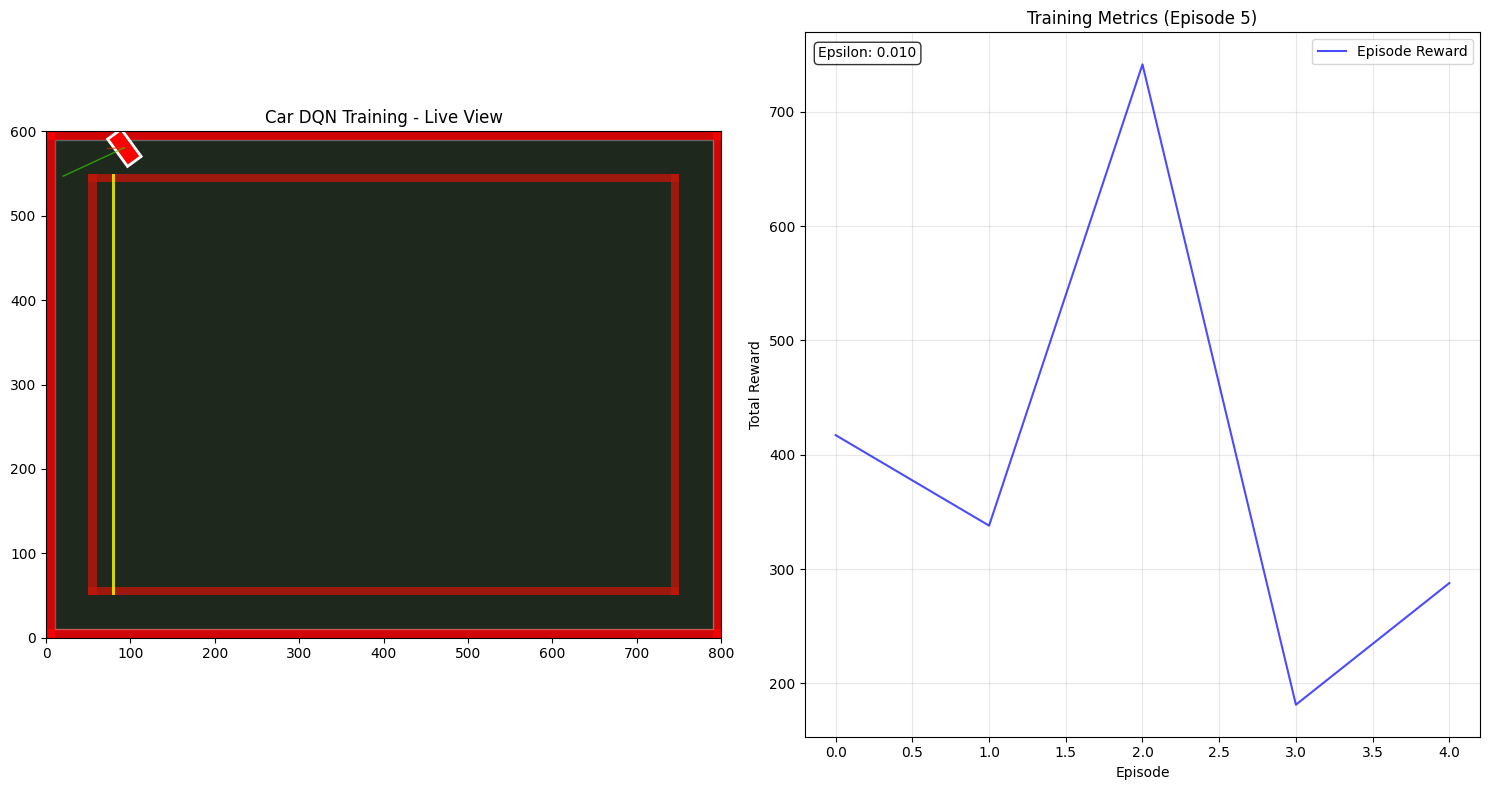

Running Episode 6/15...
  Episode 6: Reward = 365.77, Steps = 300, Collision = True
Running Episode 7/15...
  Episode 7: Reward = 321.69, Steps = 274, Collision = True
Running Episode 8/15...
  Episode 8: Reward = 1218.31, Steps = 1000, Collision = False
Running Episode 9/15...
  Episode 9: Reward = 373.07, Steps = 308, Collision = True
Running Episode 10/15...
  Episode 10: Reward = 1100.61, Steps = 990, Collision = True


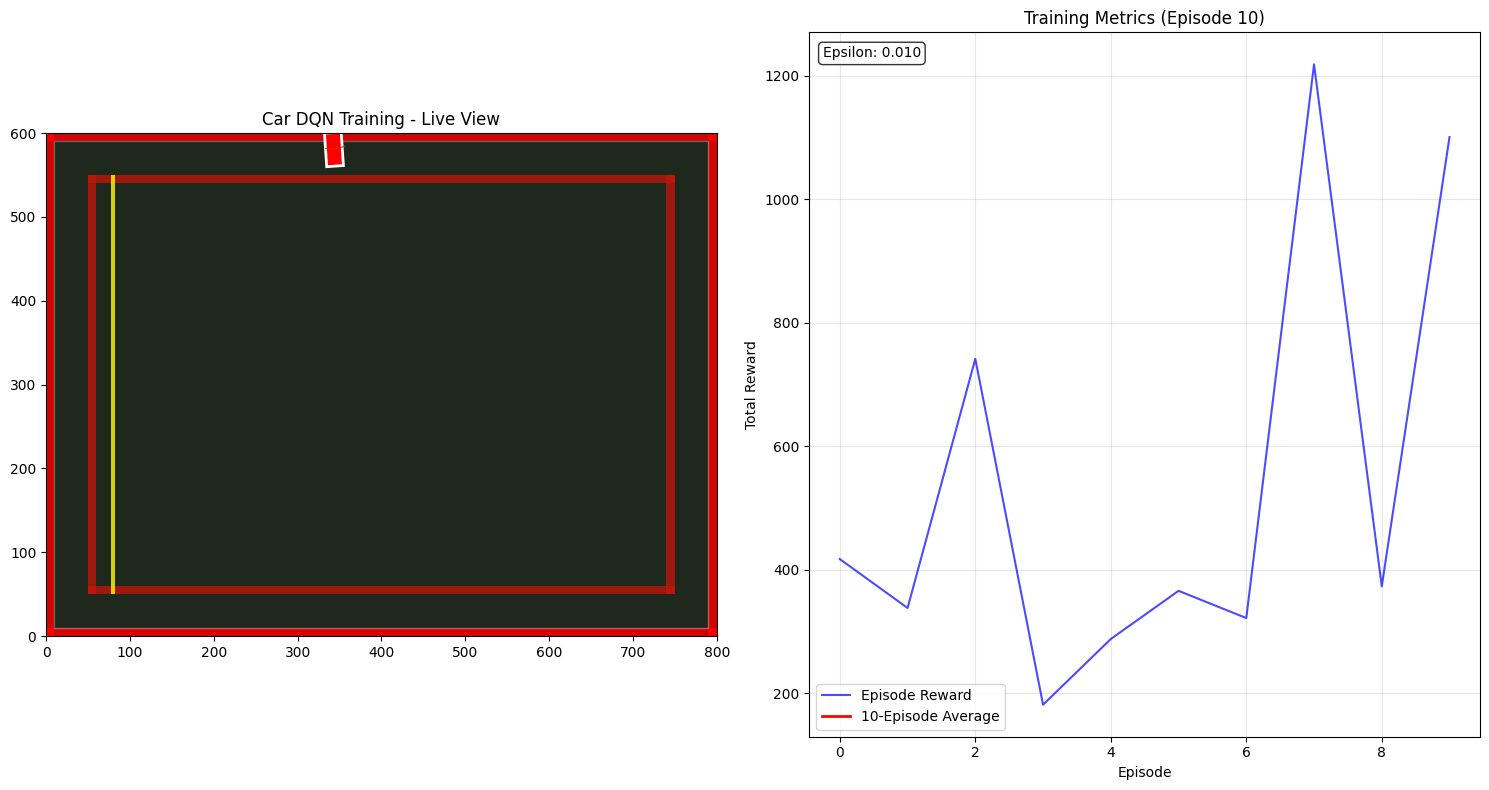

Running Episode 11/15...
  Episode 11: Reward = 347.64, Steps = 302, Collision = True
Running Episode 12/15...
  Episode 12: Reward = 216.68, Steps = 192, Collision = True
Running Episode 13/15...
  Episode 13: Reward = 544.19, Steps = 452, Collision = True
Running Episode 14/15...
  Episode 14: Reward = 120.67, Steps = 114, Collision = True
Running Episode 15/15...
  Episode 15: Reward = 297.27, Steps = 253, Collision = True


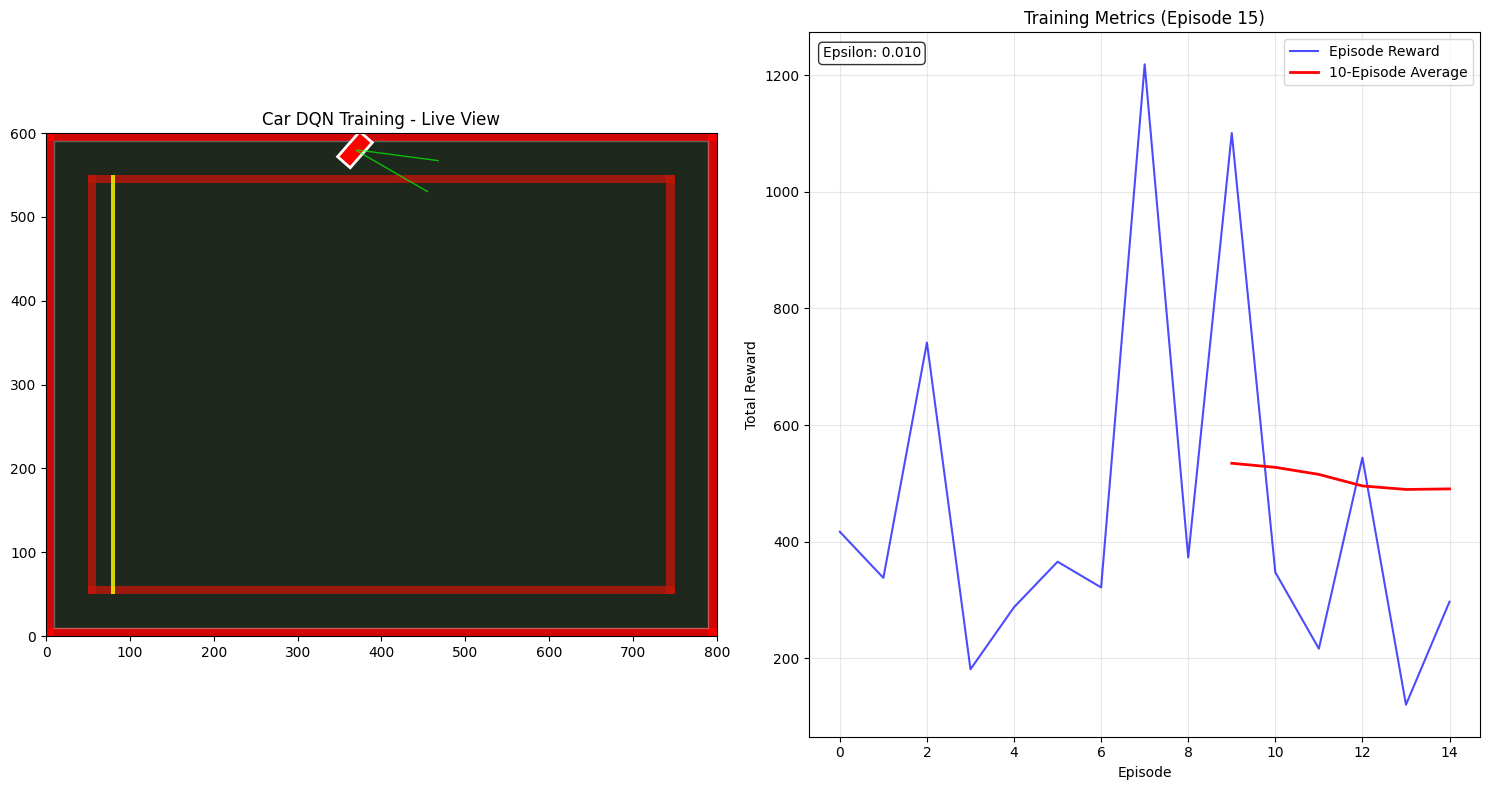

<Figure size 640x480 with 0 Axes>

------------------------------------------------------------
Training completed!
Total episodes: 15
Average reward (last 10 episodes): 490.59
Best episode reward: 1218.31
Final epsilon: 0.010


In [25]:
run_training_visualization(num_episodes=15)